In [12]:
# Import Section

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import glob
import os
import math
import csv
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Concatenate, Dropout, BatchNormalization, MaxPooling2D


In [4]:
# Paths 
Read_data="/Users/moctader/Arcada/BigDataAnalyticsThesis/data/samples.pkl"


# Read Data
df=gpd.GeoDataFrame(
    pd.read_pickle(Read_data),
    geometry="geometry"
)

In [5]:
#combine channel and label extracted

X = np.array([np.array(row['combined_channels']) for _, row in df.iterrows()])
label = np.array(df['label'])

In [8]:
# Find the unique channels(arrays) form the combined channels
unique_arrays, unique_indices = np.unique(X, axis=-1, return_index=True)


In [15]:
# Assaign other features lattitude and longitude 

features=unique_arrays
latitude=np.array([np.array(row['lat']) for _, row in df.iterrows()])
longitude=np.array([np.array(row['lon']) for _, row in df.iterrows()])

In [16]:
# Normalized the features
features = features / 255.0


In [17]:
# Perform train-test split with the same number of samples
X_feature_train, X_feature_test, X_scalar_train, X_scalar_test, y_train, y_test = train_test_split(
    features,
    np.column_stack((latitude, longitude)),
    label,
    test_size=0.2, random_state=42
)

Epoch 1/30
263/263 [==============================] - 4s 13ms/step - loss: 0.7850 - accuracy: 0.5485 - val_loss: 0.6790 - val_accuracy: 0.5987
Epoch 2/30
263/263 [==============================] - 3s 11ms/step - loss: 0.7152 - accuracy: 0.5741 - val_loss: 0.6595 - val_accuracy: 0.6094
Epoch 3/30
263/263 [==============================] - 3s 12ms/step - loss: 0.6932 - accuracy: 0.5819 - val_loss: 0.6634 - val_accuracy: 0.6030
Epoch 4/30
263/263 [==============================] - 3s 12ms/step - loss: 0.6744 - accuracy: 0.5993 - val_loss: 0.6706 - val_accuracy: 0.5901
Epoch 5/30
263/263 [==============================] - 3s 12ms/step - loss: 0.6613 - accuracy: 0.6215 - val_loss: 0.6547 - val_accuracy: 0.6030
Epoch 6/30
263/263 [==============================] - 3s 12ms/step - loss: 0.6574 - accuracy: 0.6222 - val_loss: 0.6631 - val_accuracy: 0.6545
Epoch 7/30
263/263 [==============================] - 3s 12ms/step - loss: 0.6535 - accuracy: 0.6337 - val_loss: 0.6713 - val_accuracy: 0.6266

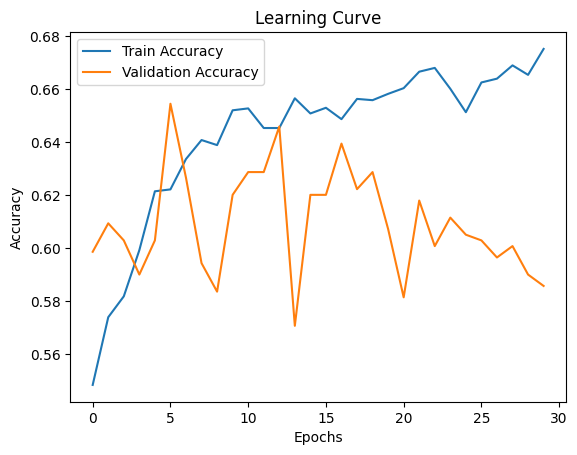

In [18]:
# Define the CNN model for processing image features
input_feature = Input(shape=(50, 50, 18))

# Convolutional layers with increasing filters, dropout, batch normalization, and max pooling
x = Conv2D(8, (3, 3), activation='relu')(input_feature)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Add MaxPooling
x = Dropout(0.2)(x)

x = Conv2D(16, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Add MaxPooling
x = Dropout(0.2)(x)

x = Conv2D(32, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Add MaxPooling
x = Dropout(0.2)(x)

# x = Conv2D(64, (3, 3), activation='relu')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)  # Add MaxPooling
# x = Dropout(0.2)(x)


x = Flatten()(x)

# Define the input layer for scalar values
input_scalar = Input(shape=(2,))  

# Concatenate flattened features and scalar inputs
merged_input = Concatenate()([x, input_scalar])

# Additional hidden layer with fewer neurons, dropout, and batch normalization
x = Dense(64, activation='relu')(merged_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_feature, input_scalar], outputs=output)

# Use the Adam optimizer with a learning rate of 0.001
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    [X_feature_train, X_scalar_train],
    y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate([X_feature_test, X_scalar_test], y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Plot learning curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
